In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from models import Unet, regressionnet, ann, Convnet1
from scripts import tools, dataset
from models.layers import *

tools.etc.set_GPU('0')
%matplotlib inline

def markJoints(img, joints):
    img = img.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(14):
        x, y = map(int,joints[i])
        if x!=-1: 
            cv2.circle(img, (x, y), 4, (0, 0, 255), thickness=-1)
            cv2.putText(img, str(i+1), (x,y), font, 0.5, (0,0,255), 2, cv2.LINE_AA)
    return img

In [2]:
All_Graph = tf.Graph()
with All_Graph.as_default():
    num_joints=14
    model_list=['Human_Detector','Human_Joint_Pointer','Human_Pose_Estimator']
    
    with tf.variable_scope(model_list[0]):
        Human_Detector = Unet.Unet((128,128,3),(128,128,3),2)
        
    with tf.variable_scope(model_list[1]):
        Human_Joint_Pointer = Convnet1.convNet(input_shape=(128,128,3),output_shape=(28,))
    with tf.variable_scope(model_list[2]):
        Human_Pose_Estimator = ann.ann(input_shape=28,output_shape=10)
        
    var_name_list = [[] for _ in range(len(model_list))]
    var_dict_list = [dict() for _ in range(len(model_list))]
    
    for var in tf.global_variables():
        var_name_list[model_list.index(var.name.split('/')[0])].append(var)
        
    for i in range(len(model_list)):
        for var in var_name_list[i]:
            var_dict_list[i].update({'/'.join(var.name.split('/')[1:]).replace(':0',''):
                                     All_Graph.get_tensor_by_name(var.name)}) 

    saver_list = [tf.train.Saver(var_list=var_dict_list[i]) for i in range(len(model_list))]

In [3]:
config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph=All_Graph)

saver_path = ['./snapshots/Human_Detector/Unet_Human_only.ckpt',
              './snapshots/Human_Joint_Pointer/convnet1_highest_pcp.ckpt',
              './snapshots/Human_Pose_Estimator/for_algotest-Copy1.ckpt']

for i in range(len(saver_path)):
    saver_list[i].restore(sess, saver_path[i])

INFO:tensorflow:Restoring parameters from ./snapshots/Human_Detector/Unet_Human_only.ckpt
INFO:tensorflow:Restoring parameters from ./snapshots/Human_Joint_Pointer/convnet1_highest_pcp.ckpt
INFO:tensorflow:Restoring parameters from ./snapshots/Human_Pose_Estimator/for_algotest-Copy1.ckpt


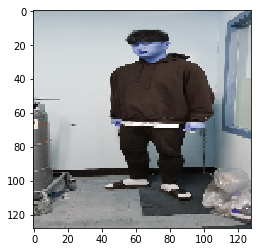

In [4]:
test_img=cv2.resize(cv2.imread('/home/hahnz/test/KakaoTalk_Photo_2018-09-19-13-50-34.jpeg'),(128,128))
#test_img=cv2.resize(cv2.imread('/home/hahnz/prof/prof_test/frame200.png'),(128,128))
#test_img=cv2.resize(cv2.imread('/home/hahnz/prof/prof_test/frame100.png'),(128,128))
#test_img=cv2.resize(cv2.imread('/home/hahnz/imgroom1/180919 14:36:52.jpg'),(128,128))
#test_img=cv2.resize(cv2.imread('/home/hahnz/imgroom1/180919 14:38:31.jpg'),(128,128))
plt.imshow(test_img)

In [11]:
#t1 = sess.run(Human_Detector.score,{Human_Detector.x:[test_img],Human_Detector.keep_prob:1.})
with All_Graph.as_default():
    t2 = sess.run(Human_Joint_Pointer.fc_regression,{Human_Joint_Pointer.x:[test_img], Human_Joint_Pointer.keep_prob:1.})
    t3 = sess.run(Human_Pose_Estimator.hypothesis, {Human_Pose_Estimator.X:t2*227/128, Human_Pose_Estimator.keep_prob:1.})
    print(t3.argmax())

2


In [6]:
t2

array([[ 87.57444 , 116.517456,  71.87835 ,  95.40564 ,  67.610985,
         82.90532 ,  86.21929 ,  81.84314 ,  84.84929 ,  94.219635,
         94.051704, 116.13017 ,  67.13491 ,  90.79182 ,  63.486744,
         89.626015,  67.87208 ,  51.898113,  96.11959 ,  51.178185,
         98.199036,  88.595146,  90.36852 ,  88.90707 ,  74.867714,
         46.824127,  75.808784,  22.870256]], dtype=float32)

In [63]:
test_img=test_it.img_set[8]

In [10]:
with All_Graph.as_default():
    sess.run()
    print(tf.global_variables())

[<tf.Variable 'Human_Detector/conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>, <tf.Variable 'Human_Detector/conv1/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Human_Detector/bn1/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Human_Detector/bn1/BatchNorm/moving_mean:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Human_Detector/bn1/BatchNorm/moving_variance:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Human_Detector/conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'Human_Detector/conv2/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Human_Detector/bn2/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Human_Detector/bn2/BatchNorm/moving_mean:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Human_Detector/bn2/BatchNorm/moving_variance:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Human_Detector/conv3/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'Human_Detector/conv3/bias:0' shape=(128,) d